# **Leaf Disease Stage Detection**

# Image Preprocessing using Tensorflow

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras

In [ ]:
images = os.listdir('/content/drive/MyDrive/potato _leaf_disease/testing/Healthy')

In [ ]:
training_url = '/content/drive/MyDrive/potato _leaf_disease/training'
testing_url = '/content/drive/MyDrive/potato _leaf_disease/testing'
validation_url = '/content/drive/MyDrive/potato _leaf_disease/validation'

In [ ]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(training_url) #,batch_size=100, by default reads images in batch of 32
testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(testing_url)

Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


In [ ]:
type(training_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
class_labels = testing_dataset.class_names      # Features

In [ ]:
len(class_labels)

3

# Visualize the data

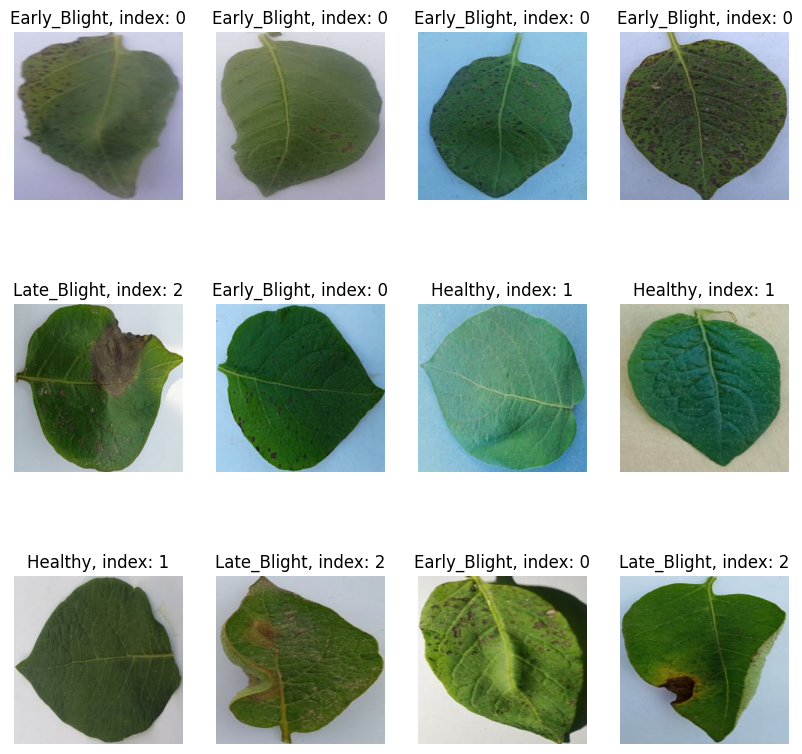

In [ ]:
# take(1) => takes specified amount of batch of data, here it have 1batch = 32 images
plt.figure(figsize=(10,10))
for image_batch,label_batch in testing_dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch.numpy()[i].astype('uint8'))    # converting to unsigned int as pixels can't be negative as well as decimal
    class_index = label_batch.numpy()[i]      # we get label of each images
    plt.title(f"{class_labels[class_index]}, index: {class_index}")      # we put labels(0,1,2) in class_labels
    plt.axis(False)
  plt.show()

In [ ]:
# Note: training_dataset.take(20), here we are taking randomly 20 batch i.e 1batch=32 images so 20batch = 32*20 => 640images for training,
#   because it will take 8to9 hrs if we take all 3k images for training
training_dataset = training_dataset.take(20).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Resizing and Rescaling**:
The below process is resizing, rescaling,etc can be also done using cv2(requires numpy) but here we are dealing with tensors now and it is more easy
to deal with it

In [ ]:
# the below is layer not a model
rescale_and_resize = keras.Sequential([
    # actions to perform step by step is specified sequentially in sequential model
    keras.layers.experimental.preprocessing.Resizing(256,256),      # resizing image to 256x256 pixel
    keras.layers.experimental.preprocessing.Rescaling(1.0/255),     # scaling img pixel between 0 to 1, ex: 142px = 0.142
])

# **Data Augmentation**
The process of **flipping, rotating**, etc the image to cover maximum possibility and for better model training for real world images.
Example: The user can give img which is upside-down or rotated 40deg etc thus data augmentation is done

In [ ]:
# data augmentation
image_augmentation = keras.Sequential([
    # actions to perform step by step
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),    # rotation between 0 to 0.2*(2*pie) and 2pie=360deg => 0 to 360deg rotation
])

# **Model Creation**
**Conv2D**: It is used to extract feature from image. here 32 features <br>
**MaxPolling**: It is used to reduce the size of image so that model have to process less data. i.e less data to compute and performance increases.
It divides the size of image into half. ex: 256x256 => 128x128

In [ ]:
# For feature detection: 1)CNN 2)Maxplolling
model = keras.models.Sequential([
    #  preprocessing layers(pipeline)
    rescale_and_resize,
    image_augmentation,

    # Feature Extraction
    # input_shape(32,...)  => 32 is the batch size of images
    keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(32,256,256,3)),  # 32->specifies 32 features to extract from image,3x3 filter to aply to extract feature
    keras.layers.MaxPooling2D((2,2)),   # 128x128   or (-1or-2or-3) i.e 125 or 126    #maxploing losses pixels becaoz it cutdown edges, #here 1st 2-represent 2x2 filter and 2nd 2-represent stride(move by 2block)

    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),    #64x64 or -1 or -2 i.e 62 (see the summary below)      (2=>2x2 filter,2 is stride size)

    # from now on below it will zoom out the image and validate the features that found aboves
    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),    #32x32

    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),    #8x8

    keras.layers.Conv2D(64,(3,3),activation='relu'),      #64 features is enough to predict the animal, ex.cat
    keras.layers.MaxPooling2D((2,2)),    #4x4

    #Deep Learning Model
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),       # model can give 1of3 output because we have 3output labels

])

In [ ]:
model.build(input_shape=(32,256,256,3))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [ ]:
model.compile(
    optimizer='adam',
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),    # from_logits=False => the loss is between 0 to 1, else between +infinity to -inifinity
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    training_dataset,
    epochs=50,
    batch_size=32,
    validation_data=validation_dataset
)

Epoch 1/50
20/20 [==============================] - 108s 5s/step - loss: 1.0789 - accuracy: 0.3984 - val_loss: 1.0502 - val_accuracy: 0.3781
Epoch 2/50
20/20 [==============================] - 99s 5s/step - loss: 1.0164 - accuracy: 0.4500 - val_loss: 0.9662 - val_accuracy: 0.4500
Epoch 3/50
20/20 [==============================] - 118s 6s/step - loss: 0.9528 - accuracy: 0.5031 - val_loss: 0.9252 - val_accuracy: 0.5797
Epoch 4/50
20/20 [==============================] - 99s 5s/step - loss: 0.9600 - accuracy: 0.5344 - val_loss: 0.8793 - val_accuracy: 0.6203
Epoch 5/50
20/20 [==============================] - 99s 5s/step - loss: 0.8725 - accuracy: 0.6281 - val_loss: 0.8760 - val_accuracy: 0.6094
Epoch 6/50
20/20 [==============================] - 99s 5s/step - loss: 0.7910 - accuracy: 0.6703 - val_loss: 0.7189 - val_accuracy: 0.6984
Epoch 7/50
20/20 [==============================] - 99s 5s/step - loss: 0.7072 - accuracy: 0.7203 - val_loss: 0.6909 - val_accuracy: 0.7219
Epoch 8/50
20/20 [

In [ ]:
model.save("/content/drive/MyDrive/Trained_Models/leaf_health_classification(salmon_joy)")

In [ ]:
model.evaluate(testing_dataset)

20/20 [==============================] - 22s 1s/step - loss: 0.0652 - accuracy: 0.9781


[0.06515698879957199, 0.9781249761581421]

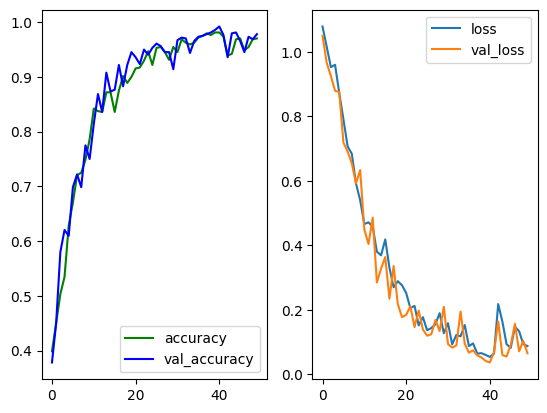

In [ ]:
# accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],'-g', label='accuracy')
plt.plot(history.history['val_accuracy'],'-b', label='val_accuracy')    # accuracy of validation_data
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()